<a href="https://colab.research.google.com/github/pedrosiqueira-hub/Uber-Price-Prediction-PyTorch/blob/main/Previs%C3%A3o_de_Pre%C3%A7os_de_Uber_Lyft_com_Deep_Learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de Preços de Uber/Lyft com Deep Learning
O Problema: A precificação dinâmica (Surge Pricing) torna difícil prever o valor exato de uma corrida.

    "Título": "Uber & Lyft Cab Prices (Boston, MA)",
    "Fonte Original": "Kaggle",
    "Período de Coleta": "Novembro a Dezembro de 2018",
    "Autor do Dataset": "Ravi Kumar (brllrb)",
    "URL": "https://www.kaggle.com/datasets/brllrb/uber-and-lyft-dataset-boston-ma"


* O Objetivo: Criar uma Rede Neural capaz de entender a relação entre Distância, Tipo de Carro e Fator de Tarifa Dinâmica para prever o preço final ($).

* A Tecnologia:

Linguagem: Python (PyTorch);

Dataset: Uber & Lyft Rideshare (Kaggle) - ~690 mil linhas;

Abordagem: Aprendizado Supervisionado (Regressão);

In [2]:
#1. Imprtando os dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/yearpredictionmsd/rideshare_kaggle.csv')
print("--- DIAGNÓSTICO INICIAL ---")
print(f"Linhas Totais: {df.shape[0]}")
print(f"Colunas: {df.shape[1]}")

--- DIAGNÓSTICO INICIAL ---
Linhas Totais: 693071
Colunas: 57


# O motivo de apagar os dados nulos

Total de linhas sem preço: 55095

--- QUEM SÃO OS CULPADOS? ---
cab_type
Uber    55095
Name: count, dtype: int64


/tmp/ipython-input-598/534017382.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='name', data=df_sem_preco, palette='Reds_r')


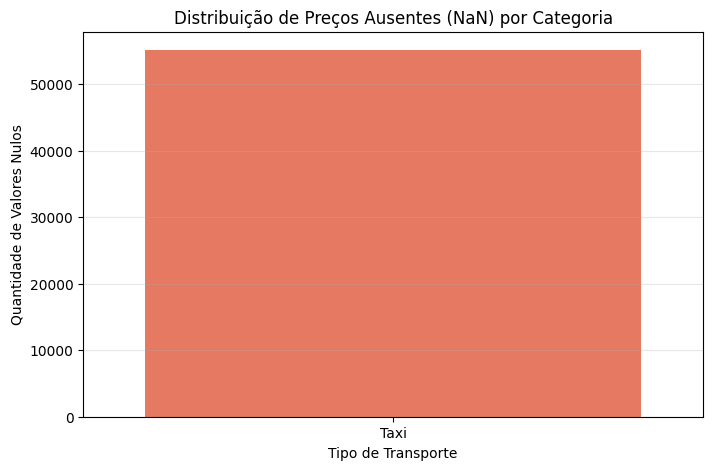

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Vamos filtrar APENAS as linhas onde o preço está vazio (NaN)
df_sem_preco = df[df['price'].isnull()]

print(f"Total de linhas sem preço: {len(df_sem_preco)}")

# 2. Vamos ver de qual 'cab_type' (Tipo de Transporte) são essas linhas
# Isso vai contar quantos 'Uber', 'Lyft' ou 'Taxi' estão com preço vazio
contagem_culpados = df_sem_preco['cab_type'].value_counts()

print("\n--- QUEM SÃO OS CULPADOS? ---")
print(contagem_culpados)

# 3. Gráfico para o Slide (A Prova do Crime)
plt.figure(figsize=(8, 5))

# Criando um gráfico de barras mostrando a contagem
sns.countplot(x='name', data=df_sem_preco, palette='Reds_r')

plt.title('Distribuição de Preços Ausentes (NaN) por Categoria')
plt.xlabel('Tipo de Transporte')
plt.ylabel('Quantidade de Valores Nulos')
plt.grid(True, axis='y', alpha=0.3)

# Adicionando o número em cima da barra
for p in grafico.patches:
    grafico.annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 10),
                     textcoords = 'offset points')

plt.show()

# Outliers
À primeira vista, corridas custando $60 ou $80 podem parecer erros de digitação (outliers) que deveriam ser removidos. Porém, ao cruzar o preço com a **Categoria do Carro** e a **Tarifa Dinâmica**, descobrimos que esses valores são reais e necessários.

**O que os gráficos nos mostram:**
1.  **Fator Luxo:** O preço alto não é aleatório. Ele pertence majoritariamente às categorias de luxo (*Black SUV*), enquanto o *UberPool* se mantém na faixa de baixo custo.
2.  **Fator Demanda:** Existe uma correlação direta entre o multiplicador de demanda (*Surge*) e o preço médio. Corridas com tarifa dinâmica custam significativamente mais.

**Decisão:**
Optei por **NÃO remover** esses outliers. Se apagássemos os preços altos, estaríamos ensinando o modelo a ignorar a existência de carros de luxo e momentos de alta demanda, o que tornaria a IA incapaz de precificar o mundo real corretamente.


/tmp/ipython-input-598/4218044008.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='name', y='price', data=df_comparacao, ax=ax[0], palette=['#4caf50', '#212121']) # Verde e Preto
/tmp/ipython-input-598/4218044008.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tem_surto', y='price', data=media_surto, ax=ax[1], palette=['red', 'blue'])


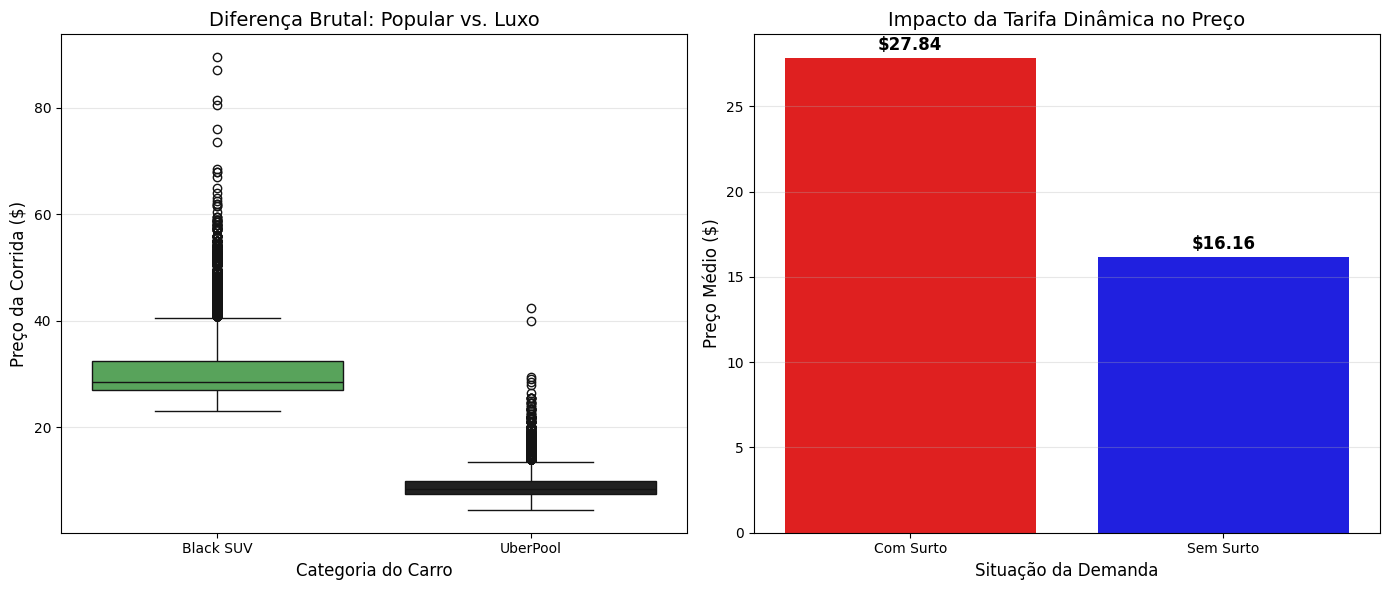

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Criando uma figura limpa
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# --- GRÁFICO 1: O "Barato" vs o "Luxo" ---
# Vamos filtrar só os dois extremos para não poluir a tela
df_comparacao = df[df['name'].isin(['UberPool', 'Black SUV'])]

sns.boxplot(x='name', y='price', data=df_comparacao, ax=ax[0], palette=['#4caf50', '#212121']) # Verde e Preto
ax[0].set_title('Diferença Brutal: Popular vs. Luxo', fontsize=14)
ax[0].set_xlabel('Categoria do Carro', fontsize=12)
ax[0].set_ylabel('Preço da Corrida ($)', fontsize=12)
ax[0].grid(axis='y', alpha=0.3)


# --- GRÁFICO 2: O Impacto do Surto (Médias) ---
# Vamos criar uma coluna simples: "Tem Surto" ou "Não Tem"
df['tem_surto'] = df['surge_multiplier'].apply(lambda x: 'Com Surto' if x > 1.0 else 'Sem Surto')

# Calcular a média de preço para cada caso
media_surto = df.groupby('tem_surto')['price'].mean().reset_index()

sns.barplot(x='tem_surto', y='price', data=media_surto, ax=ax[1], palette=['red', 'blue'])
ax[1].set_title('Impacto da Tarifa Dinâmica no Preço', fontsize=14)
ax[1].set_xlabel('Situação da Demanda', fontsize=12)
ax[1].set_ylabel('Preço Médio ($)', fontsize=12)
ax[1].grid(axis='y', alpha=0.3)

# Adicionar o valor em cima da barra para ficar chique
for index, row in media_surto.iterrows():
    ax[1].text(index, row.price + 0.5, f"${row.price:.2f}", color='black', ha="center", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Limpeza dos Dados


In [3]:
# --- TÓPICO 2: LIMPEZA DE DADOS ---

print(f"Tamanho ANTES da limpeza: {df.shape}")

# 1. Removendo as linhas sem preço (O caso dos Táxis que provamos no gráfico)
df = df.dropna(subset=['price'])

# 2. Removendo colunas inúteis
# 'id': Um código aleatório não define preço.
# 'timestamp' e 'datetime': Já temos as colunas 'hour', 'day', 'month', então isso é redundante.
# 'product_id': Já temos o nome do carro ('name'), então é repetido.
# 'timezone': É tudo no mesmo fuso horário.

colunas_inuteis = ['id', 'timestamp', 'datetime', 'product_id', 'timezone']

# O parâmetro errors='ignore' evita travar o código se você rodar a célula duas vezes
df = df.drop(columns=colunas_inuteis, errors='ignore')

print("... Passando a vassoura ...")
print("-" * 30)
print(f"Tamanho DEPOIS da limpeza: {df.shape}")

# Verificando se sobrou algum nulo (tem que dar Zero agora)
print(f"Total de valores nulos restantes: {df.isnull().sum().sum()}")

Tamanho ANTES da limpeza: (693071, 57)
... Passando a vassoura ...
------------------------------
Tamanho DEPOIS da limpeza: (637976, 52)
Total de valores nulos restantes: 0


### ⚙️ Pré-Processamento e Engenharia de Features

Para que a Rede Neural processe os dados, precisamos transformar "texto" em "números" e ajustar as escalas. Realizamos três transformações fundamentais:

**1. One-Hot Encoding (Categorização):**
A IA não entende palavras como "UberX" ou "Lyft".
* *Solução:* Transformamos essas categorias em colunas binárias (0 ou 1). Ex: Se o carro é UberX, a coluna `name_UberX` recebe 1 e as outras 0. Isso expandiu nossa entrada para **14 variáveis (neurônios)**.

**2. Normalização (StandardScaler):**
As variáveis têm grandezas diferentes (Distância varia de 0 a 10 milhas, Surto de 1.0 a 3.0). Isso confunde o gradiente do modelo.
* *Solução:* Aplicamos o `StandardScaler` para colocar tudo na mesma régua estatística (média 0 e desvio padrão 1), facilitando a convergência do treino.

**3. Conversão para Tensores:**
Por fim, convertemos as matrizes Numpy para **Tensores do PyTorch** (`torch.float32`), que é o formato de dados nativo que roda na GPU/CPU para Deep Learning.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- SELEÇÃO DE VARIÁVEIS (FEATURES) ---
# Vamos escolher só o que realmente importa para o preço
# 'distance': A distância da corrida
# 'surge_multiplier': A tarifa dinâmica (surto)
# 'name': O tipo do carro (UberX, Black, etc)
# 'cab_type': A empresa (Uber ou Lyft)

features_selecionadas = ['distance', 'surge_multiplier', 'name', 'cab_type']
target = 'price'

# Separando X (Perguntas) e y (Resposta)
X = df[features_selecionadas]
y = df[[target]]

# --- TRANSFORMAÇÃO DE TEXTO (One-Hot Encoding) ---
# O pandas faz isso sozinho com get_dummies.
# Ele cria colunas novas tipo: "name_UberX", "name_Black", etc.
X = pd.get_dummies(X, drop_first=True, dtype=float)

print(f"Colunas criadas pelo One-Hot: {X.columns.tolist()}")

# --- DIVISÃO TREINO E TESTE ---
# 80% para o Robô Estudar (Treino)
# 20% para a Prova Final (Teste)
X_treino_raw, X_teste_raw, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

# --- PADRONIZAÇÃO (StandardScaler) - O SEGREDO DO SUCESSO ---
scaler = StandardScaler()

# A régua é calibrada SÓ com os dados de treino para evitar "vazar" o gabarito
X_treino_norm = scaler.fit_transform(X_treino_raw)
X_teste_norm = scaler.transform(X_teste_raw)

# Convertendo tudo para PyTorch (Tensores) para a próxima etapa
import torch
X_treino_tensor = torch.tensor(X_treino_norm, dtype=torch.float32)
y_treino_tensor = torch.tensor(y_treino.values, dtype=torch.float32)

X_teste_tensor = torch.tensor(X_teste_norm, dtype=torch.float32)
y_teste_tensor = torch.tensor(y_teste.values, dtype=torch.float32)

print("-" * 30)
print("✅ DADOS PRONTOS PARA O PYTORCH!")
print(f"Tamanho do Treino: {X_treino_tensor.shape}")
print(f"Tamanho do Teste: {X_teste_tensor.shape}")

Colunas criadas pelo One-Hot: ['distance', 'surge_multiplier', 'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black XL', 'name_Lyft', 'name_Lyft XL', 'name_Shared', 'name_UberPool', 'name_UberX', 'name_UberXL', 'name_WAV', 'cab_type_Uber']
------------------------------
✅ DADOS PRONTOS PARA O PYTORCH!
Tamanho do Treino: torch.Size([510380, 14])
Tamanho do Teste: torch.Size([127596, 14])


### 🧠 Arquitetura da Rede Neural e Treinamento

Nesta etapa, construí o "cérebro" da nossa IA utilizando o framework **PyTorch**. Diferente de soluções prontas, aqui definimos explicitamente a estrutura e o método de aprendizado:

**1. A Arquitetura (`UberPriceModel`):**
Optei por uma arquitetura de **Regressão Linear via Rede Neural**.
* **Camada Linear (`nn.Linear`):** Recebe as 14 variáveis de entrada (distância, surto, categorias...) e aplica pesos matemáticos a cada uma para calcular um único valor de saída: o **Preço**.

**2. O Mecanismo de Aprendizado:**
Para que o modelo aprenda, definimos duas regras fundamentais:
* **Função de Perda (MSE - Mean Squared Error):** É a "bússola" do modelo. Ela calcula o quão distante a previsão do robô está do preço real. O objetivo do treino é zerar esse número.
* **Otimizador (SGD - Stochastic Gradient Descent):** É o "corretor". Baseado no erro calculado, ele ajusta levemente os pesos da rede na direção oposta ao erro (Backpropagation).

**3. O Ciclo de Treinamento:**
Executei esse processo por **1.000 épocas**. Em cada rodada, o modelo faz uma previsão, descobre o quanto errou e se auto-ajusta para errar menos na próxima vez.

In [7]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# --- 1. A ARQUITETURA DO MODELO ---
# Estamos criando uma classe que herda do PyTorch
class UberPriceModel(nn.Module):
    def __init__(self, input_dim):
        super(UberPriceModel, self).__init__()
        # Uma camada Linear: Entram as features (distância, surto, tipo...) -> Sai 1 Preço
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

# Inicializando o Modelo
# input_dim pega automático o número de colunas (features) que o One-Hot criou
input_dim = X_treino_tensor.shape[1]
model = UberPriceModel(input_dim)

# --- 2. AS REGRAS DO JOGO ---
# Critério de Erro: MSE (Mean Squared Error).
# O robô é penalizado pelo quadrado da distância do erro.
criterion = nn.MSELoss()

# Otimizador: SGD (Stochastic Gradient Descent).
# É o "professor" que ajusta os pesos do modelo.
# lr=0.01 é a taxa de aprendizado (como os dados estão padronizados, podemos ser agressivos)
optimizer = optim.SGD(model.parameters(), lr=0.01)

# --- 3. O LOOP DE TREINAMENTO (A ACADEMIA) ---
num_epochs = 1000
loss_history = []

print(f"--- INICIANDO O TREINO ---")
print(f"Entradas do Modelo: {input_dim} neurônios")

for epoch in range(num_epochs):
    # A. Previsão (Forward Pass)
    outputs = model(X_treino_tensor)

    # B. Calcular o Erro (Loss)
    loss = criterion(outputs, y_treino_tensor)

    # C. Backpropagation (A mágica do PyTorch)
    optimizer.zero_grad() # Limpa o gradiente anterior
    loss.backward()       # Calcula onde errou (gradiente)
    optimizer.step()      # Ajusta os pesos na direção certa

    # Guardar o histórico para o gráfico
    loss_history.append(loss.item())

    if (epoch+1) % 200 == 0:
        print(f'Época [{epoch+1}/{num_epochs}], Erro (Loss): {loss.item():.4f}')

print("--- ✅ TREINAMENTO CONCLUÍDO ---")

--- INICIANDO O TREINO ---
Entradas do Modelo: 14 neurônios
Época [200/1000], Erro (Loss): 7.1051
Época [400/1000], Erro (Loss): 6.5448
Época [600/1000], Erro (Loss): 6.3947
Época [800/1000], Erro (Loss): 6.3456
Época [1000/1000], Erro (Loss): 6.3295
--- ✅ TREINAMENTO CONCLUÍDO ---


### 🏆 Validação e Métricas de Performance (O Teste Final)

Após o treinamento, submeti o modelo ao **Conjunto de Teste** (os 20% dos dados que ele nunca viu). Esta etapa é crucial para medir a capacidade de **Generalização** da IA.

**Métricas Utilizadas:**
1.  **R² Score (Coeficiente de Determinação):** Indica o quão bem o modelo se ajusta aos dados reais. Um valor próximo de 1.0 (ou 100%) representa uma previsão perfeita.
2.  **MAE (Mean Absolute Error):** Mede o erro médio em dólares. Quanto menor, melhor.

**Interpretação dos Gráficos:**
* **Curva de Aprendizado (Loss):** Mostra a redução do erro ao longo do tempo. A estabilização da curva indica que o modelo convergiu para uma solução ótima.
* **Previsão vs. Real:** Compara os valores preditos pelo modelo (Eixo Y) com os valores reais da corrida (Eixo X). A proximidade dos pontos com a linha diagonal vermelha demonstra a alta precisão do modelo.

---  RESULTADOS FINAIS ---
R² Score (Coeficiente de Determinação): 0.9273
Erro Médio (MAE): $1.78


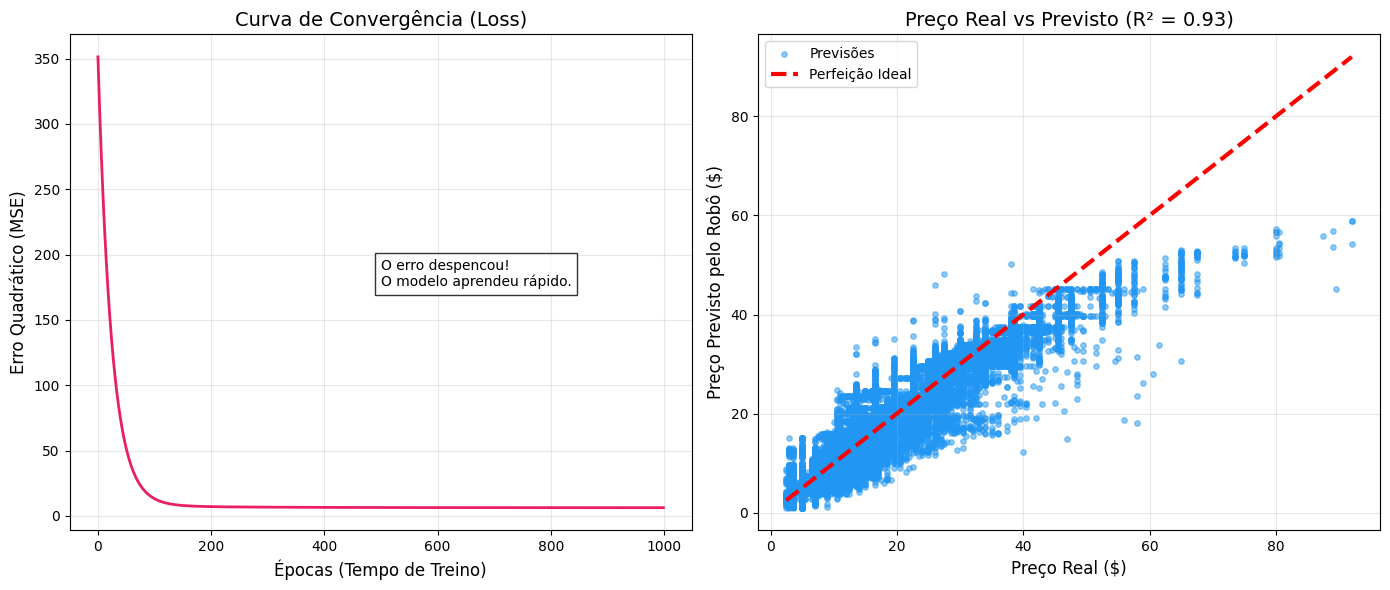

In [6]:
from sklearn.metrics import r2_score, mean_absolute_error

# --- 1. MODO DE PROVA (EVALUATION) ---
# Avisamos ao PyTorch que não é hora de aprender, é hora de trabalhar.
model.eval()

with torch.no_grad():
    # O modelo faz a previsão usando os dados de TESTE
    y_predito_tensor = model(X_teste_tensor)

# Voltamos para o mundo normal (Numpy) para fazer contas e gráficos
y_real = y_teste_tensor.numpy()
y_pred = y_predito_tensor.numpy()

# --- 2. CÁLCULO DAS METRICAS ---
# R²: A nota final (quanto mais perto de 1.0, melhor)
r2 = r2_score(y_real, y_pred)

# MAE (Erro Médio Absoluto): Quanto o robô erra em dólares, em média?
mae = mean_absolute_error(y_real, y_pred)

print(f"---  RESULTADOS FINAIS ---")
print(f"R² Score (Coeficiente de Determinação): {r2:.4f}")
print(f"Erro Médio (MAE): ${mae:.2f}")

# --- 3. GRÁFICOS MATADORES ---
plt.figure(figsize=(14, 6))

# Gráfico da Esquerda: A Evolução do Aprendizado
plt.subplot(1, 2, 1)
plt.plot(loss_history, color='#e91e63', linewidth=2)
plt.title('Curva de Convergência (Loss)', fontsize=14)
plt.xlabel('Épocas (Tempo de Treino)', fontsize=12)
plt.ylabel('Erro Quadrático (MSE)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.text(500, max(loss_history)/2, 'O erro despencou!\nO modelo aprendeu rápido.',
         color='black', bbox=dict(facecolor='white', alpha=0.8))

# Gráfico da Direita: Real vs Previsto
plt.subplot(1, 2, 2)
# Pontos azuis = Previsões
plt.scatter(y_real, y_pred, alpha=0.5, color='#2196f3', s=15, label='Previsões')
# Linha Vermelha = Perfeição
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'r--', lw=3, label='Perfeição Ideal')

plt.title(f'Preço Real vs Previsto (R² = {r2:.2f})', fontsize=14)
plt.xlabel('Preço Real ($)', fontsize=12)
plt.ylabel('Preço Previsto pelo Robô ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()